# Importar bibliotecas para Web Scraping

In [1]:
from bs4 import BeautifulSoup
import pandas as pd
import requests
import re

# Importar bibliotecas para visualização de dados

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Data Scraping

### Escolha da base de dados

O site escolhido foi o chess.com, na página de ratings FIDE. A página contém uma tabela com os melhores jogadores de xadrez do mundo, com informações como nome, título, ranking, país, rating FIDE clássico, rating rápido e rating blitz.

Nota: O site oficial da FIDE não foi selecionado pois a tabela era gerada por código JavaScript, o que dificultaria a extração dos dados.

In [3]:
base_url = 'https://www.chess.com/ratings'

### Minerar os dados da página de ratings.

O código de extração dos dados foi feito em uma função para, posteriormente, ser chamada em um loop para extrair os dados de mais de uma página.

In [4]:
def scrape_page(url):
    html = requests.get(url)
    soup = BeautifulSoup(html.content, 'lxml')

    table = soup.find('table', class_='table-component')

    headers = []
    for i in table.find_all('th'):
        header = i.text.strip()

        # A coluna 'Name' contém diferentes informações, então vamos dividir ela em 3 colunas
        if header == 'Name':
            headers.extend(['Title', 'Name', 'Country'])
        else:
            headers.append(header)

    df = pd.DataFrame(columns=headers)

    rows = table.find_all('tr')
    for row in rows[1:]:  # Pula o cabeçalho
        data = row.find_all('td')
        row_data = []

        for cell in data:
            player_div = cell.find(
                'div', class_='master-players-rating-user-wrapper')

            if player_div:
                # Title = GM, IM, FM, etc.
                title_div = player_div.find(
                    'div', class_='user-chess-title')
                title = title_div.text.strip() if title_div else ''

                player_name = cell.find(
                    'a', class_='master-players-rating-username')
                name = player_name.text.strip().replace(
                    '\n', '').replace('\r', '') if player_name else ''

                # Por causa da guerra, jogadores russos estão sem bandeira e nome do país ou como 'International'
                # Então, vamos padronizar tudo para 'International'
                country_div = player_div.find(
                    'div', {'data-cy': 'user-country-flag'})
                country = country_div.get(
                    'v-tooltip', '').strip() if country_div else ''
                country = country if country else 'International'

                row_data.extend([title, name, country])
            else:
                row_data.extend(
                    [cell.text.strip().replace('\n', '').replace('\r', '')])

        # As vezes existe alguns números e espaços junto com o rank
        # Esses números são para indicar atualizações na posição do jogador, então vamos remover
        if len(row_data) > 0:
            match = re.search(r'#\d+', row_data[0])
            row_data[0] = match.group(0) if match else row_data[0]

            df.loc[len(df)] = row_data

    return df

### Extrair todos os dados

Foi feita a extração dos dados de 100 páginas, totalizando 4997 jogadores.

In [5]:
all_data = []

for page in range(1, 101):
    url = f'{base_url}?page={page}'
    df = scrape_page(url)
    all_data.append(df)

df = pd.concat(all_data, ignore_index=True)
df.drop(columns=['Change'], inplace=True)

n_total = len(df)
print(f'Total number of players: {n_total}')

df

Total number of players: 4997


,Rank,Title,Name,Country,Classical,Rapid,Blitz
0,#1,GM,Magnus Carlsen,Norway,2832,2827,2888
1,#2,GM,Hikaru Nakamura,United States,2802,2746,2874
2,#3,GM,Fabiano Caruana,United States,2793,2777,2795
3,#4,GM,Arjun Erigaisi,India,2778,2671,2740
4,#5,GM,Ian Nepomniachtchi,International,2767,2753,2777
...,...,...,...,...,...,...,...
4992,#4996,FM,Maksym Dubnevych,Ukraine,2267,2260,2229
4993,#4997,,Alfonso Lopez Gonzalez,Spain,2267,2168,2190
4994,#4998,WGM,Josefine Heinemann,Germany,2267,2202,2304
4995,#4999,FM,Georgi Tomov,Bulgaria,2267,2241,2222


# Tratamento dos dados

O número dos ratings estavam em formato de string, então foi feita a conversão numérica. Caso ocorresse algum erro na conversão, o valor seria substituído por NaN.

Alguns jogadores não possuem ratins de rápido e blitz, então foi feita a substituição por NaN.

In [6]:
df[['Classical', 'Rapid', 'Blitz']] = df[['Classical', 'Rapid', 'Blitz']].apply(pd.to_numeric, errors='coerce')

df['Rapid'].replace(0, np.nan, inplace=True)
df['Blitz'].replace(0, np.nan, inplace=True)

df

,Rank,Title,Name,Country,Classical,Rapid,Blitz
0,#1,GM,Magnus Carlsen,Norway,2832,2827.0,2888.0
1,#2,GM,Hikaru Nakamura,United States,2802,2746.0,2874.0
2,#3,GM,Fabiano Caruana,United States,2793,2777.0,2795.0
3,#4,GM,Arjun Erigaisi,India,2778,2671.0,2740.0
4,#5,GM,Ian Nepomniachtchi,International,2767,2753.0,2777.0
...,...,...,...,...,...,...,...
4992,#4996,FM,Maksym Dubnevych,Ukraine,2267,2260.0,2229.0
4993,#4997,,Alfonso Lopez Gonzalez,Spain,2267,2168.0,2190.0
4994,#4998,WGM,Josefine Heinemann,Germany,2267,2202.0,2304.0
4995,#4999,FM,Georgi Tomov,Bulgaria,2267,2241.0,2222.0


# Análise dos dados

### Dados Estatísticos

In [7]:
stats = df[['Classical', 'Rapid', 'Blitz']].describe()
print("Statistical data:")
print(stats)

Statistical data:
         Classical        Rapid        Blitz
count  4997.000000  4330.000000  4410.000000
mean   2384.084251  2344.399307  2338.769841
std      95.578215   126.783428   129.741386
min    2267.000000  1749.000000  1752.000000
25%    2309.000000  2260.250000  2252.000000
50%    2362.000000  2336.000000  2330.000000
75%    2434.000000  2423.000000  2418.000000
max    2832.000000  2827.000000  2888.000000


### Filtrar os jogadores com mais de 2600 de rating clássico

In [8]:
df_filt = df[df['Classical'] > 2600]
df_filt

,Rank,Title,Name,Country,Classical,Rapid,Blitz
0,#1,GM,Magnus Carlsen,Norway,2832,2827.0,2888.0
1,#2,GM,Hikaru Nakamura,United States,2802,2746.0,2874.0
2,#3,GM,Fabiano Caruana,United States,2793,2777.0,2795.0
3,#4,GM,Arjun Erigaisi,India,2778,2671.0,2740.0
4,#5,GM,Ian Nepomniachtchi,International,2767,2753.0,2777.0
...,...,...,...,...,...,...,...
169,#171,GM,Ediz Gurel,Türkiye,2602,2421.0,2465.0
170,#172,GM,Eltaj Safarli,Azerbaijan,2602,2614.0,2665.0
171,#173,GM,Zhou Weiqi,China,2602,2607.0,2590.0
172,#174,GM,Marc'Andria Maurizzi,France,2601,2444.0,2464.0


### Top 10 países

Foi feita uma tabela com o top 10 países de rating clássico em 3 classificações diferentes: por quantidade de jogadores, por média de rating e por mediana de rating. Todos considerando apenas jogadores com mais de 2600 de rating clássico. Para a média e mediana, foi considerado apenas os países com mais de 5 jogadores na lista.

In [9]:
top_countries = {}

top_countries['Top 10 by Count'] = df_filt['Country'].value_counts(
).nlargest(10).index.tolist()

# Filtrar os países com pelo menos 5 jogadores
country_counts = df_filt['Country'].value_counts()

df_filt2 = df_filt[df_filt['Country'].isin(
    country_counts[country_counts >= 5].index)]

median_country = df_filt2.groupby('Country')['Classical'].median()
top_countries['Top 10 by Median'] = median_country.nlargest(10).index.tolist()

mean_country = df_filt2.groupby('Country')['Classical'].mean()
top_countries['Top 10 by Mean'] = mean_country.nlargest(10).index.tolist()

# Criar o DataFrame com os resultados
df_top_countries = pd.DataFrame(top_countries)
df_top_countries

,Top 10 by Count,Top 10 by Median,Top 10 by Mean
0,United States,Netherlands,United States
1,India,Uzbekistan,Uzbekistan
2,International,England,India
3,China,United States,Netherlands
4,Ukraine,India,International
5,Armenia,International,France
6,Spain,France,China
7,Azerbaijan,Ukraine,England
8,Germany,China,Azerbaijan
9,Hungary,Germany,Germany


### Interseção entre as 3 classificações

Alguns países aparecem em mais de uma classificação, então foi feita uma tabela com a interseção entre as 3 classificações. Isso resultou em 5 países, formando um "top 5".

In [10]:
top_countries['Intersetion'] = [country for country in top_countries['Top 10 by Count']
                                if country in top_countries['Top 10 by Mean'] and country in top_countries['Top 10 by Median']]

top_countries['Intersetion']

['United States', 'India', 'International', 'China', 'Germany']

In [11]:
df_top_countries_int = df_filt[df_filt['Country'].isin(top_countries['Intersetion'])]
df_top_countries_int

,Rank,Title,Name,Country,Classical,Rapid,Blitz
1,#2,GM,Hikaru Nakamura,United States,2802,2746.0,2874.0
2,#3,GM,Fabiano Caruana,United States,2793,2777.0,2795.0
3,#4,GM,Arjun Erigaisi,India,2778,2671.0,2740.0
4,#5,GM,Ian Nepomniachtchi,International,2767,2753.0,2777.0
5,#6,GM,Gukesh Dommaraju,India,2766,2654.0,2615.0
...,...,...,...,...,...,...,...
154,#156,GM,Lu Shanglei,China,2609,2626.0,2638.0
159,#161,GM,Mikhail Al Antipov,United States,2606,2591.0,2545.0
164,#166,GM,Jan Gustafsson,Germany,2604,2641.0,2519.0
166,#168,FM,Vladimir Afromeev,International,2603,NaN,2623.0


### Distribuição do rating clássico por país (Top 5 países - Interseção)

Foi plotado um gráfico com distribuição do rating clássico dos jogadores para os paóses encontrados na interseção entre as 3 classificações.
Por cima do boxplot, foi adicionado os pontos individuais dos dados, permitindo visualizar melhor a dispersão e a densidade dos ratings de cada país.

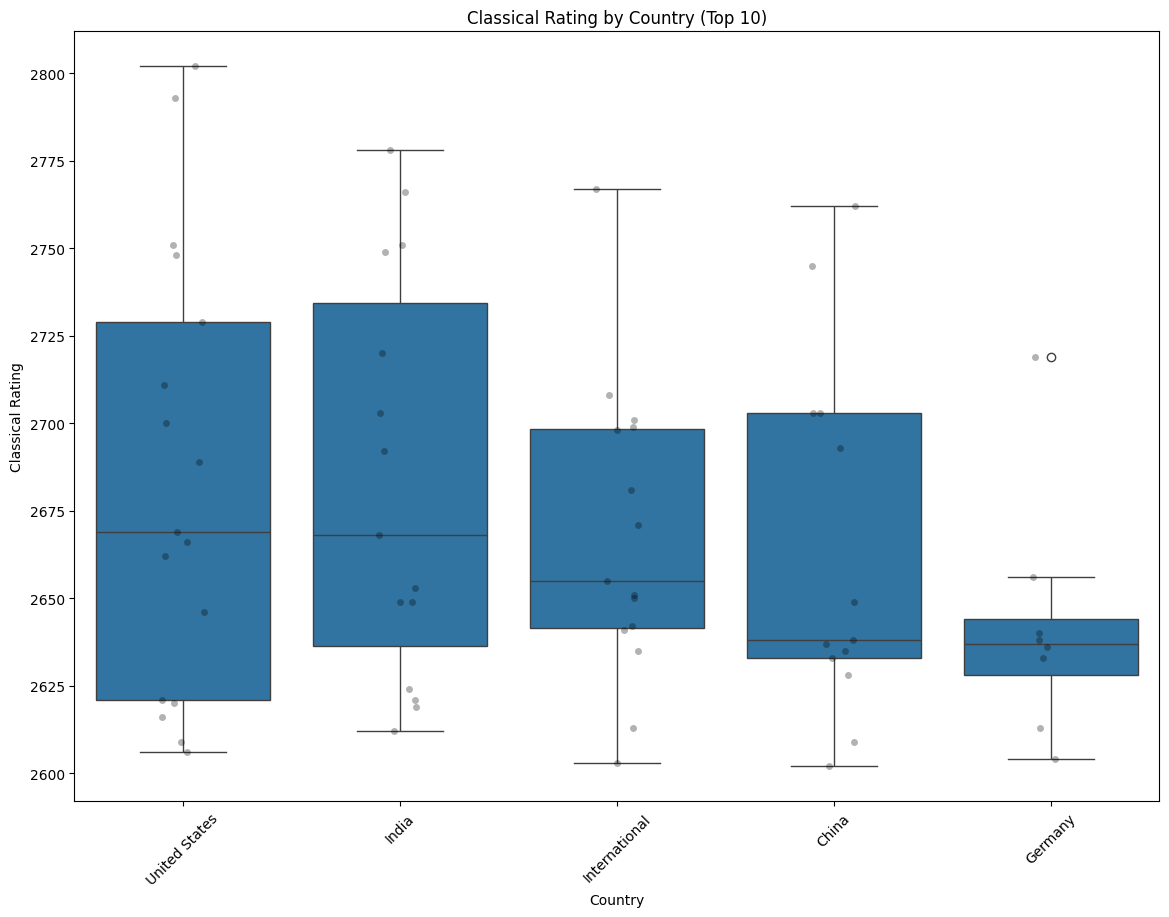

In [18]:
plt.figure(figsize=(14, 10))

sns.boxplot(x='Country', y='Classical', data=df_top_countries_int)

# Adiciona os pontos para melhor visualização da distribuição
sns.stripplot(x='Country', y='Classical', data=df_top_countries_int,
              jitter=True, color='k', alpha=0.3, dodge=True)

plt.title('Classical Rating by Country (Top 10)')
plt.xlabel('Country')
plt.ylabel('Classical Rating')
plt.xticks(rotation=45)
plt.show()

### Matriz de correlação dos ratings clássico, rápido e blitz

Por fim, foi feita uma matriz de correlação entre os ratings clássico, rápido e blitz. Alguns jogadores não possuem ratings nas modalidades de bliz e rápido, então esses valores foram desconsiderados.
Como a correlação entre as modalidades é alta, foi concluído que um jogador com um rating alto em uma, tende a ter um rating alto nas outras modalidades.

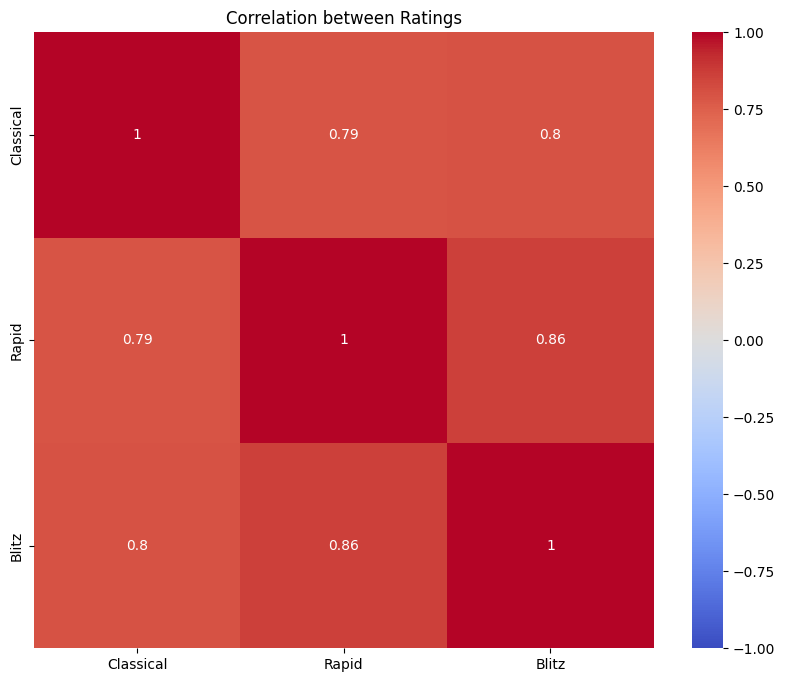

In [13]:
df_filt3 = df[(df['Classical'] > 0) & (df['Rapid'] > 0) & (df['Blitz'] > 0)]

plt.figure(figsize=(10, 8))
sns.heatmap(df_filt3[['Classical', 'Rapid', 'Blitz']].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation between Ratings')
plt.show()